In [223]:
import io
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from itertools import product
from sklearn.metrics import mean_absolute_error

## Carregamento dos dados da Soja

In [224]:
dct = {}
dct['codigo'] = 'soja'

In [225]:
df = pd.read_pickle(f'../dados/cepea-{dct["codigo"]}.p')

In [226]:
# Converte index para data
df.index = pd.to_datetime(df.index, format='%d/%m/%Y')

# Slice para somente o período desejado
df = df['01/01/2007':'01/01/2021']

In [227]:
# Como uma possível sazonalidade nos preços deve ter ciclo anual, com variação mensal, 
# faremos o resample da série para a média de cada mês (colocamos no início do mês por convenção, mas ideal seria fim do mês)
df_mes = df.resample('MS').mean()
df.isnull().any()

preco_real     False
preco_dolar    False
dtype: bool

#### Rendimento (produtividade por área) da soja

In [228]:
rendimento = pd.read_pickle('../dados/rendimento_soja.p')
rendimento.columns =['prd_dd']

df_join = df_mes.join(rendimento,how="inner")
df_join = df_join.asfreq('MS')

df_join.corr()

preco_real  preco_dolar    prd_dd
preco_real     1.000000     0.077259  0.558455
preco_dolar    0.077259     1.000000 -0.349639
prd_dd         0.558455    -0.349639  1.000000

In [229]:
df_join

preco_real  preco_dolar  prd_dd
data                                       
2007-01-01   33.676364    15.747273    2726
2007-02-01   34.709444    16.549444    2739
2007-03-01   34.005909    16.287273    2752
2007-04-01   31.956000    15.724000    2781
2007-05-01   32.123636    16.228636    2850
...                ...          ...     ...
2020-08-01  128.591905    23.546667    3265
2020-09-01  141.199048    26.131905    3275
2020-10-01  159.635238    28.357619    3279
2020-11-01  164.992500    30.437500    3280
2020-12-01  152.562500    29.680500    3280

[168 rows x 3 columns]

In [230]:
df_join.drop('preco_real', axis=1, inplace=True)

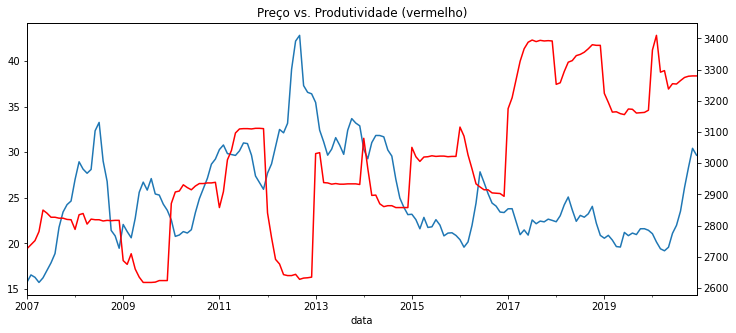

In [231]:
def plot_2axis(ds, title=None, lag=None): # Recebe dataframe com 2 colunas
    fig0, ax0 = plt.subplots()
    ax1 = ax0.twinx()

    if title: plt.title(title)
    ds.iloc[:,0].plot(kind='line', ax=ax0, figsize=(12,5))
    
    shft = ds.iloc[:,0].shift()
    shft.iloc[0] = ds.iloc[0,0]
    if lag == True: shft.plot(kind='line', ax=ax0, style='-')

    ds.iloc[:,1].plot(kind='line', secondary_y=True, ax=ax1, color='r')
    plt.show()
    plt.close()
    
plot_2axis(df_join, "Preço vs. Produtividade (vermelho)")

In [232]:
# Converte para séries estacionárias (primeira diferença)
data = np.log(df_join).diff().dropna()
print(df_join.shape)
print(data.shape)
# data possui um item a menos que df_join, pois perde o primeiro com a derivada.

(168, 2)
(167, 2)


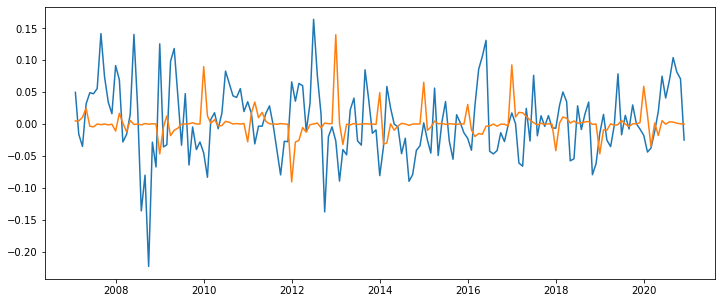

In [233]:
# Plota série tornada estacionária
plt.figure(figsize=(12,5))
plt.plot(data)
plt.show()

In [234]:
# Separa Train Test (12 meses = ano 2020)
test_size = 12
train = data[:-test_size]
test = data[-test_size:]

In [235]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base.datetools import dates_from_str

# Fit somente no set de treino
maxlags = 10

model = VAR(train)
results = model.fit(maxlags=maxlags, ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 29, Jan, 2021
Time:                     18:29:19
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -13.4680
Nobs:                     154.000    HQIC:                  -13.5382
Log likelihood:           615.111    FPE:                1.25763e-06
AIC:                     -13.5863    Det(Omega_mle):     1.21003e-06
--------------------------------------------------------------------
Results for equation preco_dolar
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.001427         0.004203            0.340           0.734
L1.preco_dolar         0.321088         0.076194            4.214           0.000
L1.prd_dd             -0.419639         0.199354  

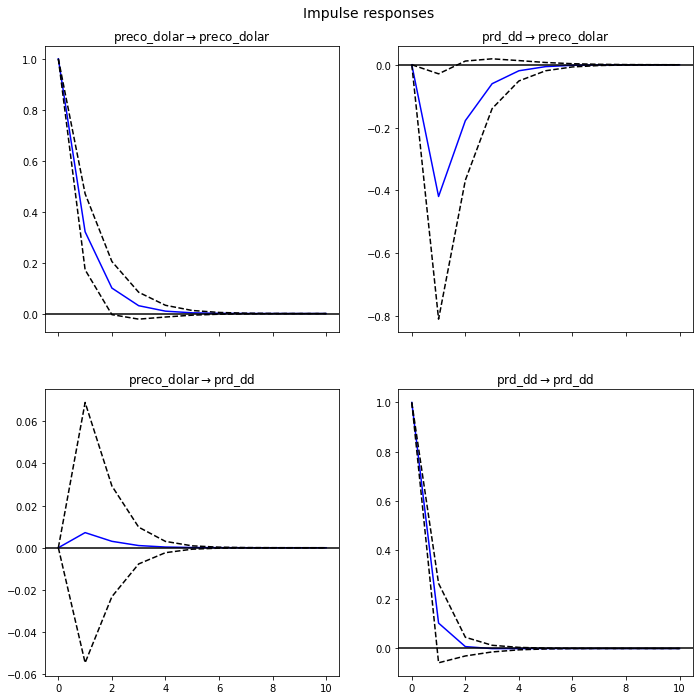

In [264]:
irf = results.irf(10)
irf.plot()
plt.show()

In [260]:
# Ordem do modelo, escolhida pelo critério AIC
lag_order = results.k_ar
print("lag_order ",lag_order)

lag_order  1


In [238]:
def gera_inputs(tr, tt, lags):
    ret = []
    size = tt.shape[0]
    full = tr.append(tt)
    for e in range(size):
        ret.append(full[-size+e-lags:-size+e if -size+e < 0 else None])
    return ret

forecasts_input = gera_inputs(train, test, lag_order)
# forecasts_input

In [259]:
# Gera Predições
price_forecasts = []

for e in forecasts_input:
    price_forecasts.append(results.forecast(e.values, 1)[0][0])
    
# price_forecasts # para o ano 2020

In [240]:
def revert(last_absolute_value, transformada): 
    # Recebe: Escalar do último ponto absoluto anterior às diferenciadas E pandas series ou numpy com valores transformados
    s = transformada if type(transformada) == np.ndarray else transformada.to_numpy()
    first = np.log(last_absolute_value)
    a_retornar = np.insert(s, 0, first, axis=0)
    return pd.Series(np.exp(a_retornar.cumsum())[1:])

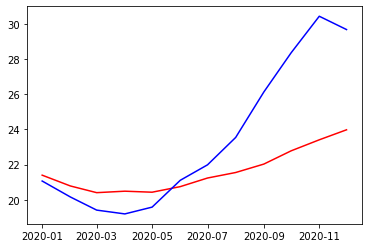

In [241]:
# Transformação reversa
# Pega o último valor antes do set de test (-test_size-1)
invert_forecasts = revert(df_join.preco_dolar[-test_size-1:-test_size], np.array(price_forecasts))

# Tudo ok, porque todas as previsões são in sample
invert_forecasts.index = test.index

plt.plot(invert_forecasts, color='r')
plt.plot(df_join.preco_dolar[-test_size:], color='b')

In [258]:
# Teste diferenças
# d_fore['prod'] = 1 toda vez que a previsão acertou a direção da variação do preço para o próximo mês
#                  0 quando errou a direção do preço

d_fore = pd.DataFrame(dtype="float")
d_fore['forecasts'] = np.array(invert_forecasts.values)
d_fore['real'] = df_join.preco_dolar[-test_size:].values
d_fore = d_fore.apply(np.gradient)
d_fore['prod'] = d_fore.apply(np.prod, axis=1)
d_fore['prod'] = d_fore['prod'].apply(lambda x: 1 if x > 0 else 0)

print(f'Acurácia da direção da previsão: ', d_fore["prod"].value_counts()[1]/d_fore.shape[0])

Acurácia da direção da previsão:  0.9166666666666666


In [243]:
# previsão do modelo para todo o período de teste
# geração de inputs
ret = []
size = data.shape[0]
for e in range(size):
    ee = e + 1
    ret.append(data[-size+ee-lag_order:-size+ee if -size+ee < 0 else None])

In [245]:
def correct_size(x):
    if len(x) == lag_order: return True
ret1 = list(filter(correct_size, ret))
ret1

[            preco_dolar    prd_dd
 data                             
 2007-02-01     0.049685  0.004758,
             preco_dolar    prd_dd
 data                             
 2007-03-01    -0.015969  0.004735,
             preco_dolar    prd_dd
 data                             
 2007-04-01    -0.035196  0.010483,
             preco_dolar    prd_dd
 data                             
 2007-05-01     0.031589  0.024508,
             preco_dolar    prd_dd
 data                             
 2007-06-01      0.04908 -0.003515,
             preco_dolar    prd_dd
 data                             
 2007-07-01      0.04747 -0.004588,
             preco_dolar  prd_dd
 data                           
 2007-08-01     0.055536     0.0,
             preco_dolar    prd_dd
 data                             
 2007-09-01     0.141791 -0.001062,
             preco_dolar  prd_dd
 data                           
 2007-10-01     0.073984     0.0,
             preco_dolar    prd_dd
 data                  

In [246]:
# ret 
# para lag_order = 1,
# começa em fev/07 e termina em 12/2020, predições começarão em mar/07 e termina em 01/21 (essa deve ser descartada)
# enfim, necessário realinhamento dos dados após predições

In [247]:
print("Total de inputs: ", len(ret1))

# ret = ret[lag_order:]
# print(len(ret))

tr_for = []
for e in ret1:
    tr_for.append(results.forecast(e.values, 1)[0][0])
    
print("Tamanho das predicoes: ", len(tr_for))

print("Porém, dados não alinhados.")

Total de inputs:  167
Tamanho das predicoes:  167
Porém, dados não alinhados.


{df_join} possui uma observação a mais que {data}, por causa da função diff()

In [248]:
# Último valor absoluto antes da primeira previsão (relativa, em diff)
df_join.preco_dolar[lag_order:lag_order+1]

data
2007-02-01    16.549444
Freq: MS, Name: preco_dolar, dtype: float64

In [249]:
# Reverter as transformações das previsões
# O sistema sempre prevê um passo à frente
previsao_revertida = revert(df_join.preco_dolar[lag_order:lag_order+1], np.array(tr_for))

print(previsao_revertida.shape[0])

167


In [250]:
df_join.preco_dolar[lag_order+1:] # até dezembro/2020

data
2007-03-01    16.287273
2007-04-01    15.724000
2007-05-01    16.228636
2007-06-01    17.045000
2007-07-01    17.873636
                ...    
2020-08-01    23.546667
2020-09-01    26.131905
2020-10-01    28.357619
2020-11-01    30.437500
2020-12-01    29.680500
Freq: MS, Name: preco_dolar, Length: 166, dtype: float64

In [251]:
jan_2021 = previsao_revertida[-1:]
prev_insample = previsao_revertida[:-1]
prev_insample.index = df_join.preco_dolar[lag_order+1:].index
jan_2021

166    23.821531
dtype: float64

In [252]:
prev_insample

data
2007-03-01    16.806013
2007-04-01    16.710709
2007-05-01    16.473898
2007-06-01    16.495089
2007-07-01    16.805797
                ...    
2020-08-01    21.552219
2020-09-01    22.031434
2020-10-01    22.784099
2020-11-01    23.411405
2020-12-01    23.980695
Freq: MS, Length: 166, dtype: float64

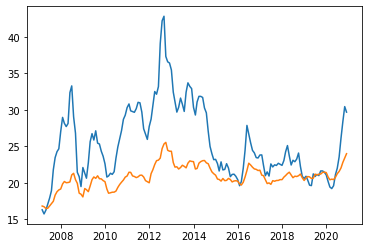

In [253]:
y = df_join.preco_dolar[lag_order+1:]
y_hat = prev_insample

plt.plot(y)
plt.plot(y_hat)

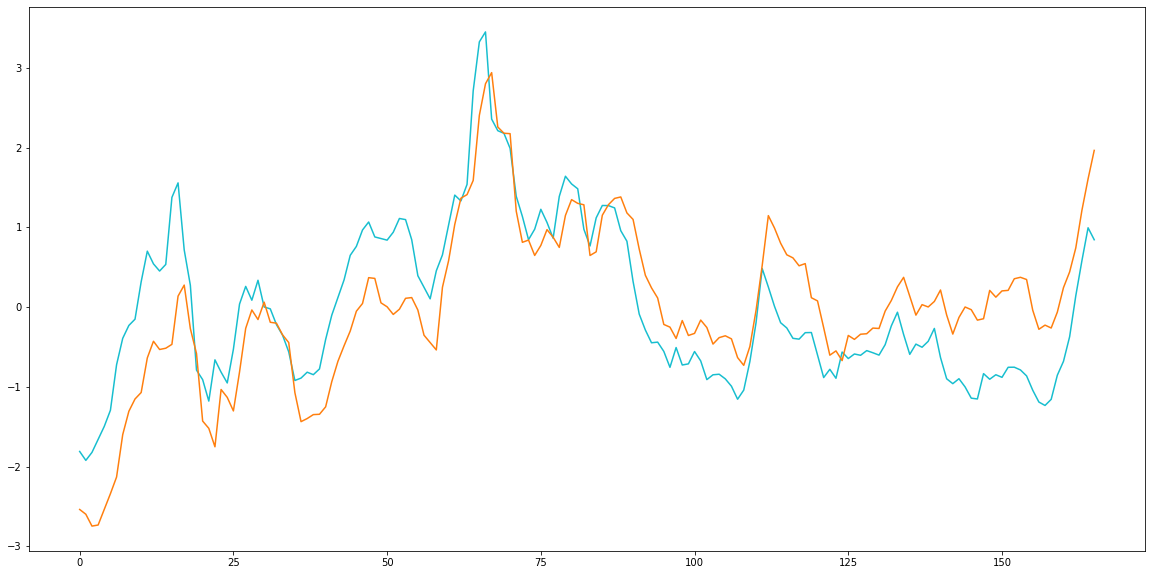

In [254]:
# Plot novamente, com dados normalizados
from sklearn.preprocessing import StandardScaler as sc

s1 = sc()
s2 = sc()
y_norm = s1.fit_transform(y.values.reshape(-1,1))
yhat_norm = s2.fit_transform(y_hat.values.reshape(-1,1))

plt.figure(figsize=(20,10))
plt.plot(y_norm, color='tab:cyan')
plt.plot(yhat_norm, color='tab:orange')

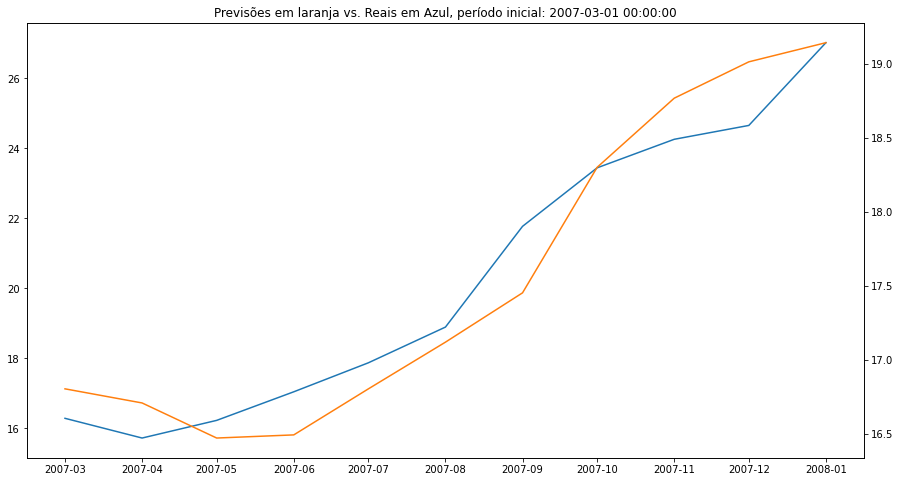

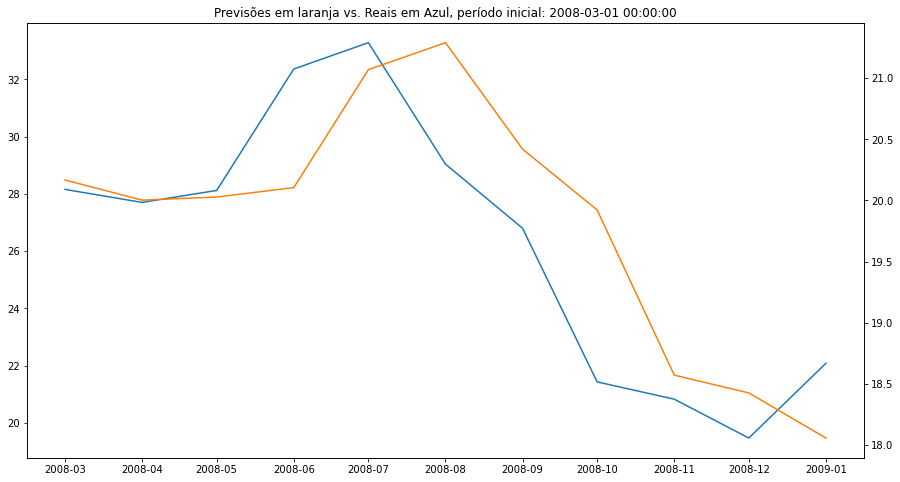

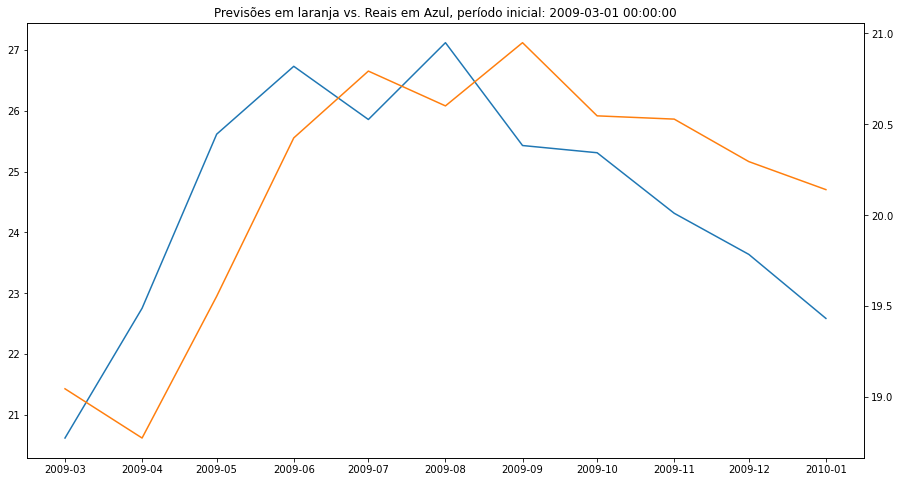

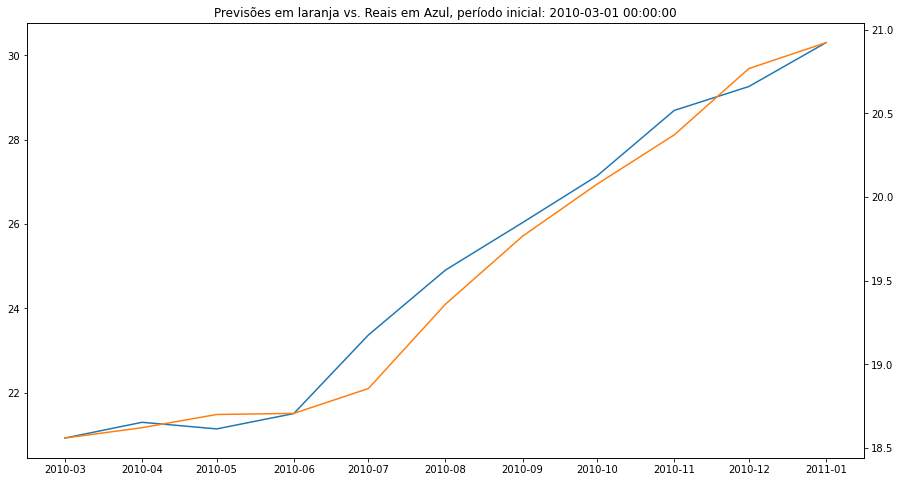

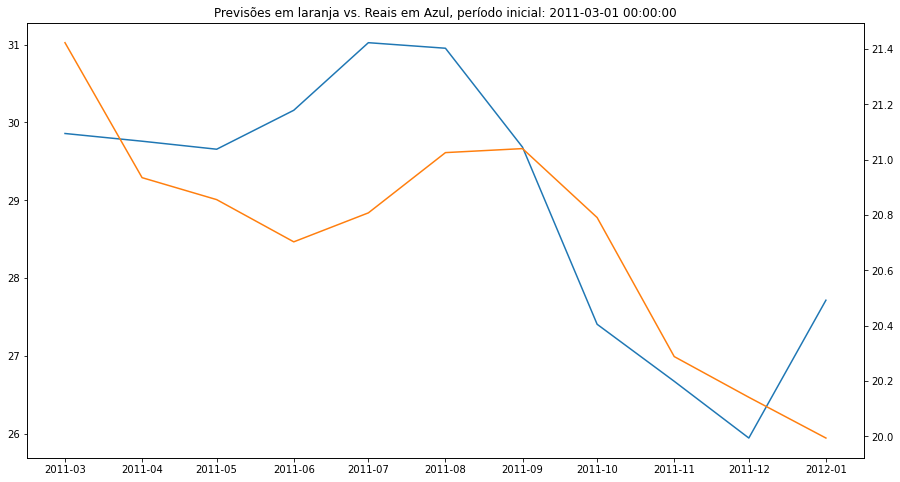

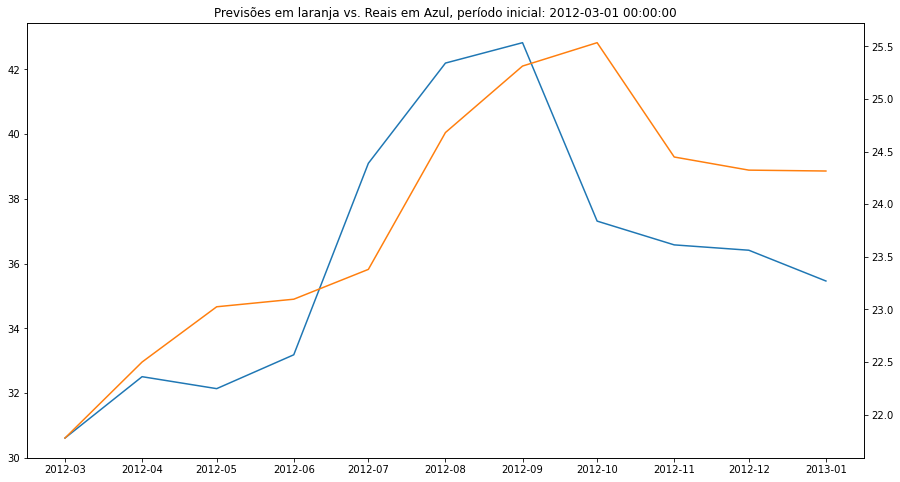

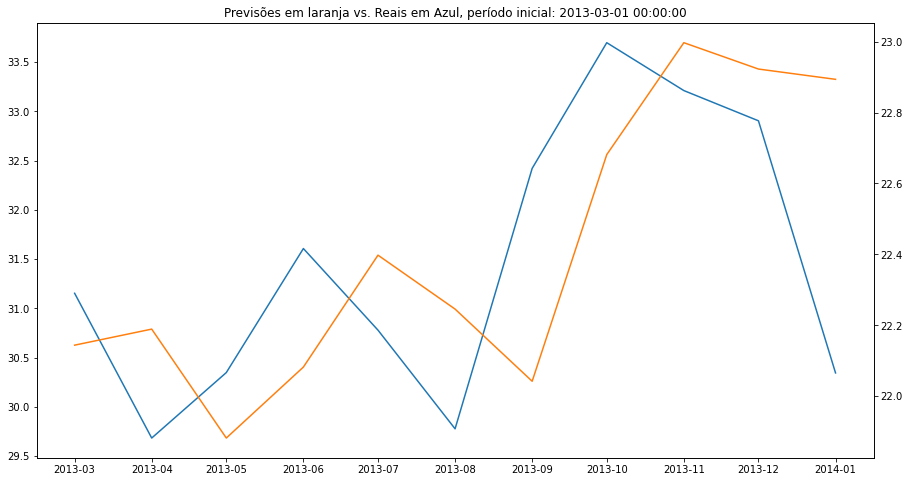

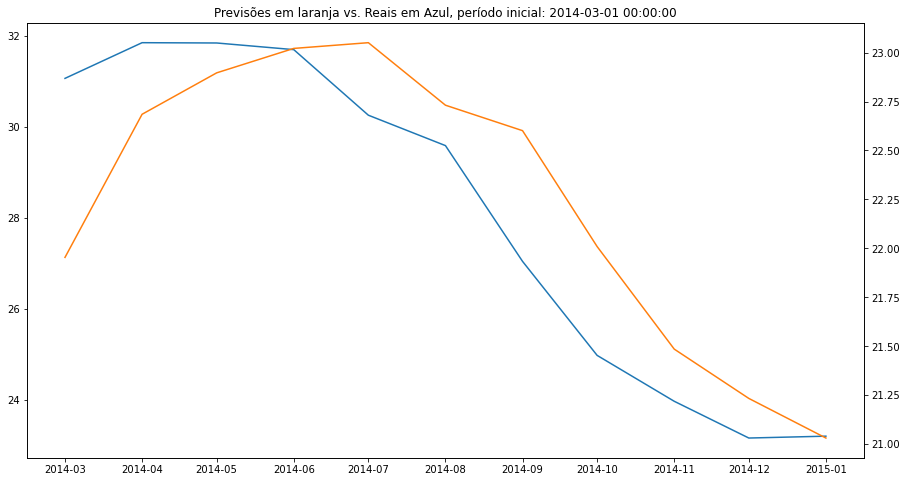

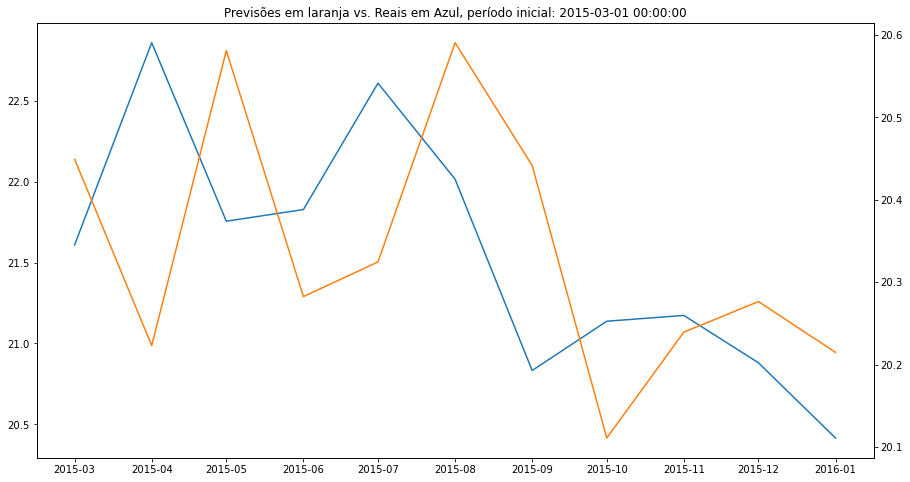

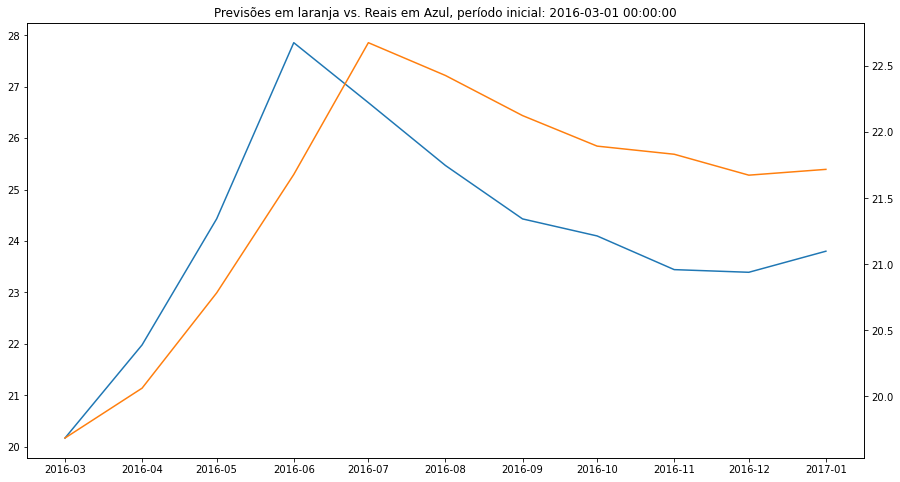

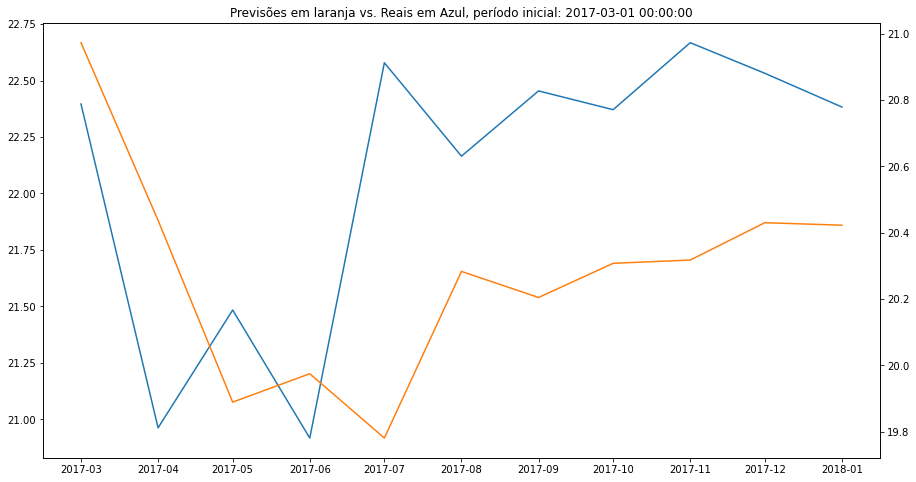

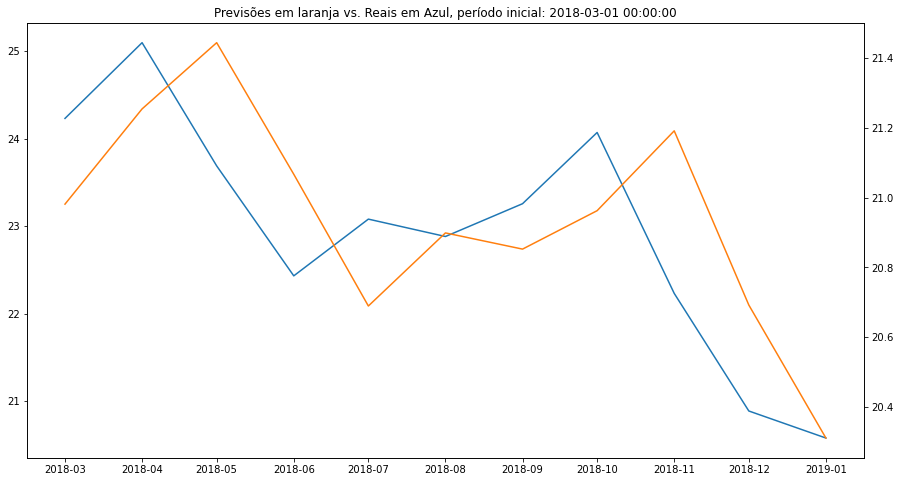

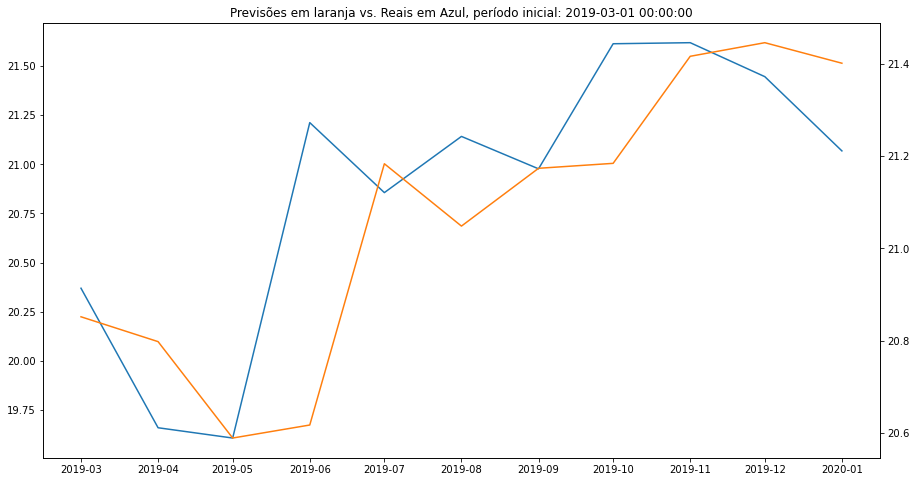

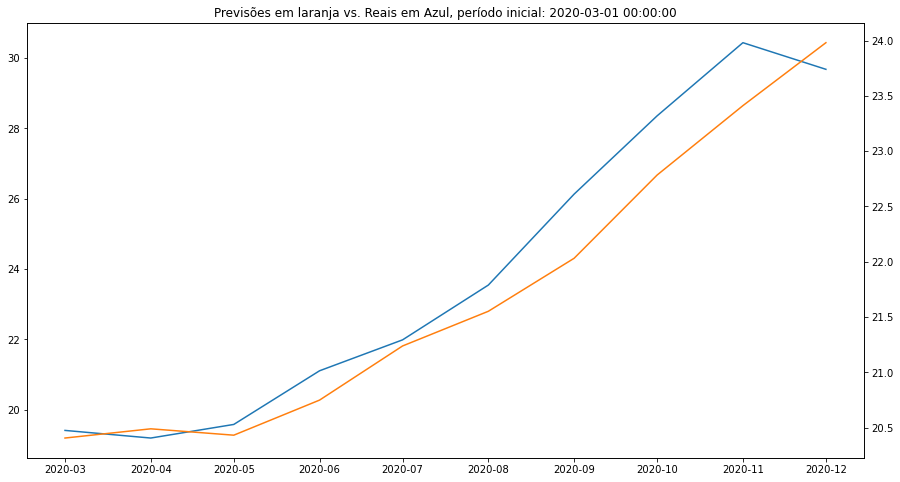

In [255]:
for e in range(int(df_join.shape[0]/12)):
    def slice(var):
        return var[12*e:(12)*(e+1)-1]
    
    fig, ax1 = plt.subplots(figsize=(15,8))
    ax1.plot(slice(y))
    ax2 = ax1.twinx()
    ax2.plot(slice(y_hat), color="tab:orange")
    plt.title(f'Previsões em laranja vs. Reais em Azul, período inicial: {slice(y).index[0]}')
    plt.show()

In [256]:
# Modelo não foi capaz de superar o baseline de lag+1

print("Erro do modelo: ", mean_absolute_error(y, y_hat)) # MAE
print("Erro do baseline: ", mean_absolute_error(y, y.shift().fillna(method='bfill')), " x(t+1)=x(t)") # MAE

Erro do modelo:  4.675930029520678
Erro do baseline:  1.1069500397003418  x(t+1)=x(t)
